In [1]:
import treegp
import matplotlib.pyplot as plt
import torch
import numpy as np
import gpytorch
import math
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

In [2]:
train_x = torch.linspace(0, 1, 2000)
train_y = torch.sin(train_x * (4 * math.pi) + torch.randn(train_x.size()) * 0.2)

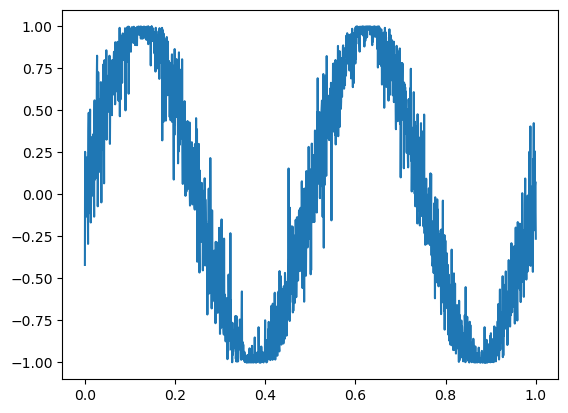

In [3]:
plt.plot(train_x, train_y)

In [ ]:
class GPRegressionModelKISS(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModelKISS, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that. Here we are using a grid that has the same number of points as the training data (a ratio of 1.0). Performance can be sensitive to this parameter, so you may want to adjust it for your own problem on a validation set.
        grid_size = gpytorch.utils.grid.choose_grid_size(train_x, 1.0)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.RBFKernel(), grid_size=grid_size, num_dims=1
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [5]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)

smoke_test = False
training_iterations = 2 if smoke_test else 30


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    print(i)
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

NameError: name 'GPRegressionModel' is not defined

In [ ]:
start = time.time()

model.eval()
likelihood.eval()

# The gpytorch.settings.fast_pred_var flag activates LOVE (for fast variances)
# See https://arxiv.org/abs/1803.06058
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    prediction = likelihood(model(test_x))
    mean = prediction.mean
    # Get lower and upper predictive bounds
    # lower, upper = prediction.confidence_region()

end = time.time()

print(end - start)

In [ ]:
plt.plot(test_x, mean)

In [165]:
class gp_sklearn():

    def __init__(self, std=2, correlation_length=1., white_noise=0.):

        self.std = std
        self.l = correlation_length
        self.white_noise  = white_noise

    def fit(self, x, y):
        alpha = self.white_noise**2
        self.kernel = self.std**2 * RBF(length_scale=self.l)
        self.gp =  GaussianProcessRegressor(kernel=self.kernel, alpha=alpha, optimizer=None)
        self.gp.fit(x, y)

    def predict(self, x):
        y_pred = self.gp.predict(x)
        return y_pred


class GPRegressionModelEXACT(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModelEXACT, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


class gp_torch():

    def __init__(self, std=2, correlation_length=1., white_noise=0.):
    
        #self.hypers = {
        #    # 'likelihood.noise_covar.noise': torch.tensor(white_noise),
        #    'covar_module.base_kernel.lengthscale': torch.tensor(correlation_length),
        #    'covar_module.outputscale': torch.tensor(std),
        #}
        print('ok')

    def fit(self, x, y):

        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()# noise_constraint=gpytorch.constraints.GreaterThan(1e-15))
        self.model = GPRegressionModelEXACT(x, y, self.likelihood)
        # self.model.initialize(**self.hypers)
        self.model.eval()
        self.likelihood.eval()

    def predict(self, x):

        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            prediction = self.likelihood(self.model(x))
            y_predict = prediction.mean
        return y_predict

test_x = torch.linspace(0, 2, 100)

In [169]:
start = time.time()
gps =  gp_sklearn(std=2, correlation_length=1., white_noise=np.sqrt(1e-10))
gps.fit(train_x.reshape((len(train_x), 1)), train_y)
ys = gps.predict(test_x.reshape((len(test_x), 1)))
end = time.time()
print(end-start)

start = time.time()
gpt = gp_torch(std=2., correlation_length=0.1, white_noise=np.sqrt(1e-10))
gpt.fit(train_x, train_y)
yt = gpt.predict(test_x)
end = time.time()
print(end-start)

0.15212559700012207
ok
0.1238243579864502


(-2.0, 2.0)

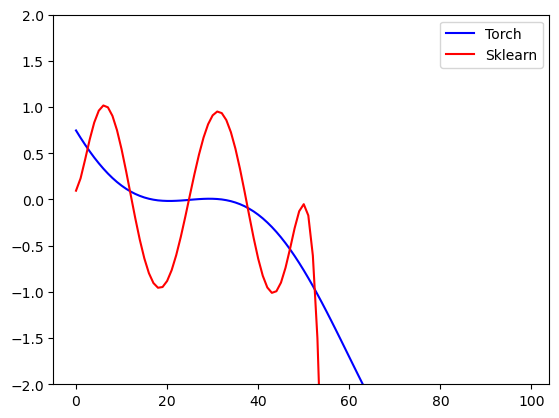

In [170]:
plt.plot(yt,'b', label='Torch')
plt.plot(ys, 'r', label='Sklearn')
plt.legend()
plt.ylim(-2,2)

In [64]:
gpt.model.hyperparameters

<bound method Module.hyperparameters of GPRegressionModelEXACT(
  (likelihood): GaussianLikelihood(
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ConstantMean()
  (covar_module): ScaleKernel(
    (base_kernel): RBFKernel(
      (raw_lengthscale_constraint): Positive()
    )
    (raw_outputscale_constraint): Positive()
  )
)>

In [157]:
# Assuming `model` is your GPyTorch model
for name, param in gpt.model.named_parameters():
    print(f'{name}: {param.item()}')

likelihood.noise_covar.raw_noise: 0.0
mean_module.raw_constant: 0.0
covar_module.raw_outputscale: 1.8545866012573242
covar_module.base_kernel.raw_lengthscale: 0.5413248538970947


In [163]:
np.exp(0.5)

1.6487212707001282

In [171]:
# Assuming `model.covar_module` is your kernel module
for name, param in gpt.model.covar_module.named_parameters():
    print(f'{name}: {param.item()}')

raw_outputscale: 0.0
base_kernel.raw_lengthscale: 0.0


In [173]:
# Print hyperparameters of the likelihood (if your model uses a Gaussian likelihood for example)
print("\nLikelihood Parameters:")
for name, param in gpt.model.likelihood.named_parameters():
    print(f'{name}: {param.data}')


Likelihood Parameters:
noise_covar.raw_noise: tensor([0.])


In [176]:
np.exp(np.sqrt(0.5413248538970947))

2.0870421398848236